## Importing the libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

## Loading Data

In [2]:
DIRECTORY = "/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [3]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Data Splitting

In [4]:
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.25,stratify=labels,random_state=42)

In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

## Loading MobileNet Model

In [6]:
IMAGE_SIZE=[224,224]

mobilenet=MobileNetV2(input_shape=IMAGE_SIZE+[3],weights="imagenet",include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [7]:
x=Flatten()(mobilenet.output)
predictions=Dense(2,activation="softmax")(x)

In [8]:
for layer in mobilenet.layers:
  layer.trainable=False

In [9]:
model=Model(inputs=mobilenet.input,outputs=predictions)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [11]:
opt = Adam(lr=1e-4, decay= 1e-4 / 20)
model.compile(loss="binary_crossentropy", 
              optimizer='adam',
              metrics=["accuracy"])


## Model Training

In [12]:
history = model.fit(
	aug.flow(train_data,train_labels, batch_size=32),
	steps_per_epoch=len(train_data) // 32,
	validation_data=(test_data, test_labels),
	validation_steps=len(test_data) // 32,
	epochs=10)


Epoch 1/10
89/89 [==============================] - 39s 344ms/step - loss: 0.3899 - accuracy: 0.9137 - val_loss: 0.1449 - val_accuracy: 0.9760
Epoch 2/10
89/89 [==============================] - 29s 330ms/step - loss: 0.0886 - accuracy: 0.9887 - val_loss: 0.1859 - val_accuracy: 0.9791
Epoch 3/10
89/89 [==============================] - 29s 329ms/step - loss: 0.1057 - accuracy: 0.9868 - val_loss: 0.1907 - val_accuracy: 0.9823
Epoch 4/10
89/89 [==============================] - 29s 331ms/step - loss: 0.1334 - accuracy: 0.9867 - val_loss: 0.1213 - val_accuracy: 0.9885
Epoch 5/10
89/89 [==============================] - 29s 331ms/step - loss: 0.0701 - accuracy: 0.9970 - val_loss: 0.1250 - val_accuracy: 0.9937
Epoch 6/10
89/89 [==============================] - 30s 332ms/step - loss: 0.0496 - accuracy: 0.9937 - val_loss: 0.1477 - val_accuracy: 0.9906
Epoch 7/10
89/89 [==============================] - 30s 332ms/step - loss: 0.0512 - accuracy: 0.9949 - val_loss: 0.1663 - val_accuracy: 0.9906

In [13]:
model.save("Face_Mask_Detection.h5")

## Visualizing Results

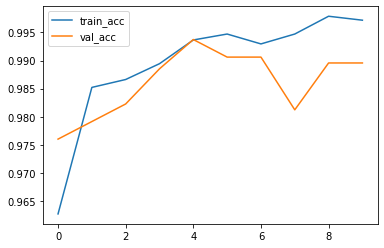

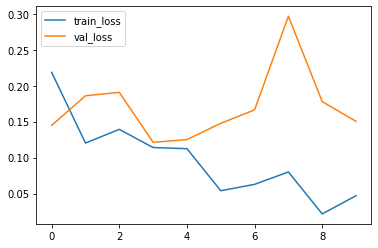

In [14]:
plt.plot(history.history['accuracy'],label="train_acc")
plt.plot(history.history['val_accuracy'],label="val_acc")
plt.legend()
plt.show()
#plt.savefig('model_acc')

plt.plot(history.history['loss'],label="train_loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.show()
#plt.savefig('model_loss')